In [1]:
from torch_geometric.datasets import PPI
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
from torch_geometric.loader import DataLoader

train_dataset = PPI(root='/tmp/PPI', split="train")
val_dataset = PPI(root='/tmp/PPI', split="val")
test_dataset = PPI(root='/tmp/PPI', split="test")
# train_dataset.transform = T.NormalizeFeatures()
# val_dataset.transform = T.NormalizeFeatures()
# test_dataset.transform = T.NormalizeFeatures()

train_loader = iter(DataLoader(train_dataset, batch_size=len(train_dataset)))
val_loader = iter(DataLoader(val_dataset, batch_size=len(val_dataset)))
test_loader = iter(DataLoader(test_dataset, batch_size=len(test_dataset)))

In [2]:
train_set = next(train_loader)
test_set = next(test_loader)
val_set = next(val_loader)

In [3]:
train_set.x

tensor([[-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        ...,
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481]])

In [4]:
from AutoTune2 import user_function
from EnsembleFramework import Framework
import torch 

hops = [3]
framework = Framework(hops_list= hops,
                      clfs=[],
                      attention_configs=[{'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None} for i in hops],
                      handle_nan=0.0,
                      gpu_idx=1,
                      user_functions=[user_function for i in hops]
                      )
train_features = framework.get_features(train_set.x, train_set.edge_index, torch.ones(train_set.x.shape[0]).type(torch.bool))[0].cpu()
val_features = framework.get_features(val_set.x, val_set.edge_index, torch.ones(val_set.x.shape[0]).type(torch.bool))[0].cpu()
test_features = framework.get_features(test_set.x, test_set.edge_index, torch.ones(test_set.x.shape[0]).type(torch.bool))[0].cpu()

/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:159: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")


In [23]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=200, hidden_layer_sizes=(512, 512, 512), learning_rate="constant", learning_rate_init=0.005)
mlp.fit(train_features, train_set.y)

MLPClassifier(hidden_layer_sizes=(512, 512, 512), learning_rate_init=0.005)

In [24]:
from sklearn.metrics import f1_score

score = f1_score(test_set.y,mlp.predict(test_features), average ="micro")
score

0.6285610451686818

In [61]:
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(MLP, self).__init__()
        self.dropout = dropout
        self.lin_conv_0 = nn.Linear(input_dim, hidden_dim)
        self.lin_0 = nn.Linear(input_dim, hidden_dim)
        self.lin_comb_0 = nn.Linear(hidden_dim, hidden_dim)

        self.lin_conv_1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin_1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin_comb_1 = nn.Linear(hidden_dim, hidden_dim)

        self.lin_conv_2 = nn.Linear(hidden_dim, output_dim)
        self.lin_2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin_comb_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, x_conv):
        x = self.lin_0(x)
        x_conv = self.lin_conv_0(x_conv)
        # x_comb = self.lin_comb_0(x_conv + x)
        # x_comb = F.elu(x_comb)
        x = F.elu(x)
        x_conv = F.elu(x_conv)
        # x_new = F.dropout(x_new, p=self.dropout, training=self.training)
        x = self.lin_1(x)
        x_conv = self.lin_conv_1(x_conv)
        # x_comb = self.lin_comb_1(x_conv + x)
        # x_comb = F.elu(x_comb)
        x = F.elu(x)
        x_conv = F.elu(x_conv)
        # x_new = F.dropout(x_new, p=self.dropout, training=self.training)
        x = self.lin_2(x)
        x_conv = self.lin_conv_2(x_conv)
        # x_comb = self.lin_comb_2(x_conv + x)
        return x_conv #x_comb      
              

In [66]:
from tqdm.notebook import tqdm
device = torch.device("cuda:1")
model = MLP(train_set.x.shape[1], 256, train_set.y.shape[1], dropout = 0.2).to(device)
optim = torch.optim.Adam(params=model.parameters(), lr = 0.0005)
EPOCHS = 5000

losses = {}
TRAIN = "train"
losses[TRAIN] = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    optim.zero_grad()
    out = model(train_set.x.to(device), train_features.to(device))
    loss = F.binary_cross_entropy_with_logits(out, train_set.y.to(device))
    losses[TRAIN].append(loss.item())
    loss.backward()
    optim.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss curves')

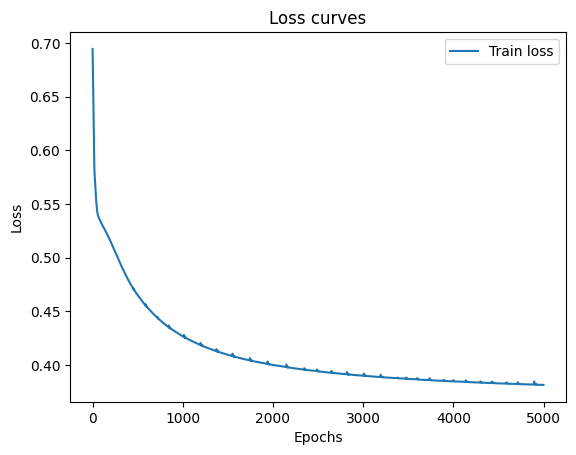

In [67]:
import matplotlib.pyplot as plt
plt.plot(range(EPOCHS), losses[TRAIN])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train loss"])
plt.title("Loss curves")

In [68]:
TEST = "test"
VAL = "val"
losses[TEST] = []
losses[VAL] = []

with torch.inference_mode():
    model.eval()
    out = model(test_set.x.to(device), test_features.to(device))
    eval_loss = F.binary_cross_entropy_with_logits(out, test_set.y.to(device))
    losses[TEST].append(eval_loss.item())
    y_pred = torch.round(torch.sigmoid(out))
    

In [69]:
from sklearn.metrics import f1_score

f1_score(test_set.y, y_pred.cpu(), average="micro")

0.642657325497221